# Classificação de Células Cancerígenas de Pulmão e Cólon

Este colab contém os treinamentos das seis redes em **20 épocas**.

Disciplina de Introdução a Aprendizagem Profunda (IF867)

Alunos:

*   Davi Monteiro Paiva (dmp)
*   Isabela Marinho Ribeiro (imr)
*   Michel Leonidas Aleixo da Silva (mlas3)

## Importação do dataset
Instalando Kaggle e o Pandas:

In [ ]:
!pip install kaggle
!pip install pandas

In [ ]:
 from google.colab import files

Upload do arquivo que contém a chave da API do Kaggle:

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davimonteiropaiva","key":"28905d1369433f07b70e90c6610431d5"}'}

Criação do diretório para a leitura da chave Kaggle:

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Autenticação e download do dataset:

In [ ]:
# Authenticate using your Kaggle API credentials
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Use the 'dataset_download_files' method to download the dataset
api.dataset_download_files('andrewmvd/lung-and-colon-cancer-histopathological-images')

# The dataset will be downloaded as a zip file, you can unzip it
import zipfile
with zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset-folder')  # Extract to a specific folder

Importação de bibliotecas:

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

Separação das pastas de cada classe:

In [ ]:
# Define the path to the dataset folder
dataset_path = '/content/dataset-folder/lung_colon_image_set'

# List the subfolders (classes) in the dataset folder
class_names = os.listdir(dataset_path)
class_names.sort()  # Sort for consistency

colon_folder = os.path.join(dataset_path, class_names[0])
lung_folder = os.path.join(dataset_path, class_names[1])

In [ ]:
lung_folder

'/content/dataset-folder/lung_colon_image_set/lung_image_sets'

## Visualização dos dados
Tecidos de cólon:

<Figure size 1500x1000 with 0 Axes>

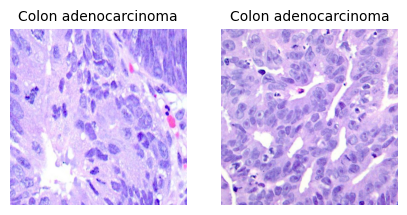

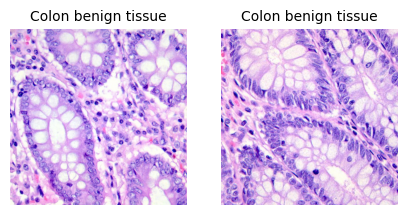

In [ ]:
plt.figure(figsize=(15, 10))
colon_path = []
titles = ["Colon adenocarcinoma", "Colon benign tissue"]

for j, image_file in enumerate(os.listdir(colon_folder)):
    image_path = os.path.join(colon_folder, image_file)
    image_files = os.listdir(image_path)

    # Load and display images in a 2x2 grid
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    colon_path.append(image_path)
    for i, ax in enumerate(axes.flat):
        path = os.path.join(image_path,image_files[i])
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(titles[j], fontsize=10)
        ax.axis('off')  # Turn off axis numbers and ticks


    plt.show()

Tecidos de pulmão:

<Figure size 1500x1000 with 0 Axes>

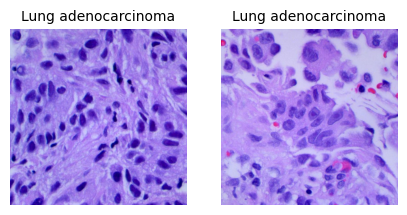

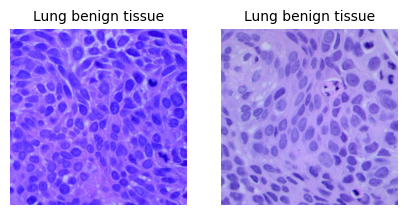

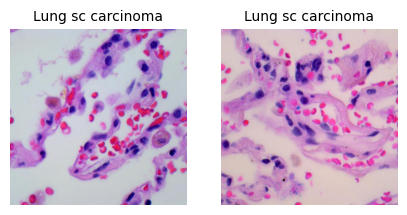

In [ ]:
plt.figure(figsize=(15, 10))
plt.clf()
titles = ["Lung adenocarcinoma", "Lung benign tissue", "Lung sc carcinoma"]
lung_path = []

for j, image_file in enumerate(os.listdir(lung_folder)):
    image_path = os.path.join(lung_folder, image_file)
    image_files = os.listdir(image_path)

    # Load and display images in a 2x2 grid
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    lung_path.append(image_path)
    for i, ax in enumerate(axes.flat):
        path = os.path.join(image_path,image_files[i])
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(titles[j], fontsize=10)
        ax.axis('off')  # Turn off axis numbers and ticks


    plt.show()

## Tratamento dos dados
Preparação das labels:

In [ ]:
Y_label = [
  'Colon Adenocarcinoma',
  'Colon Benign Tissue',
  'Lung Benign Tissue',
  'Lung Adenocarcinoma',
  'Lung Squamous Cell Carcinoma',
]
Y_label_num = [0,1,2,3,4]

Criação de array com as labels na mesma ordem dos resultados:

In [ ]:
import torch

filepaths = colon_path + lung_path

labels = []
all_imgs = []

for i, fl in enumerate(filepaths):
    flist = os.listdir(fl)
    for img in flist:
      f_path = os.path.join(fl, img)
      all_imgs.append(f_path)
      labels.append(Y_label_num[i])

labels = torch.tensor(labels)

Divisão dos dados em treino e teste usando o valor 123 para o random state, de forma a garantir que os modelos vão ser treinados com os mesmos dados:

In [ ]:
from sklearn.model_selection import train_test_split
# train dataframe
x_train, x_test, y_train, y_test = train_test_split(all_imgs, labels, test_size=0.2, shuffle= True, random_state= 123)

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.transforms as transforms

Classe que faz os dataloaders de cada modelo:

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels,  transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]


## Treinamentos e testes com redes pré-treinadas

### Resnet 18
Download do modelo pré-treinado:

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.6MB/s]


Transformação das imagens, que coloca elas em um tensor e define a dimensão para 224x244:

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Dataloaders para o treino e teste:

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Definição da loss, do otimizador e da taxa de aprendizagem:

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Definição da última camada do modelo, para que fique compatível com a quantidade de classes do dataset:

In [ ]:
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

Treinamento que coloca o modelo na GPU, se possível:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #print("loss, loss, loss", running_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainset)}")
    loss_progress.append(running_loss / len(trainset))

Training epoch 1...
Epoch [1/20] - Loss: 0.00482893737310078
Training epoch 2...
Epoch [2/20] - Loss: 0.0020565310716090606
Training epoch 3...
Epoch [3/20] - Loss: 0.0013693919851182727
Training epoch 4...
Epoch [4/20] - Loss: 0.0010147371849823685
Training epoch 5...
Epoch [5/20] - Loss: 0.0007182598197752668
Training epoch 6...
Epoch [6/20] - Loss: 0.0006651603406913637
Training epoch 7...
Epoch [7/20] - Loss: 0.0004176389747153735
Training epoch 8...
Epoch [8/20] - Loss: 0.0005354552742915984
Training epoch 9...
Epoch [9/20] - Loss: 0.00046093830788013294
Training epoch 10...
Epoch [10/20] - Loss: 0.000269521131403053
Training epoch 11...
Epoch [11/20] - Loss: 0.0002903955974332348
Training epoch 12...
Epoch [12/20] - Loss: 0.0001855571789710666
Training epoch 13...
Epoch [13/20] - Loss: 0.000488774423041832
Training epoch 14...
Epoch [14/20] - Loss: 0.0002383365454563318
Training epoch 15...
Epoch [15/20] - Loss: 0.00027559977809551127
Training epoch 16...
Epoch [16/20] - Loss: 9.

Gráfico da loss:

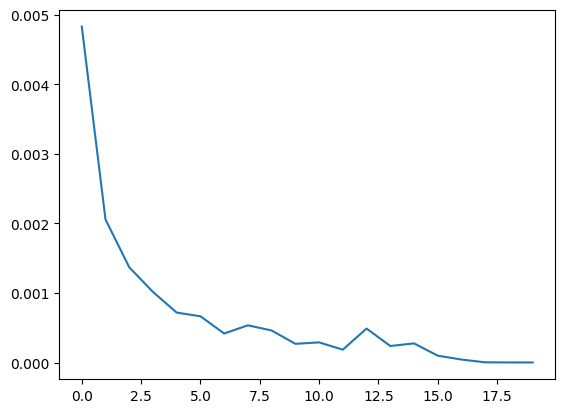

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 99.64%


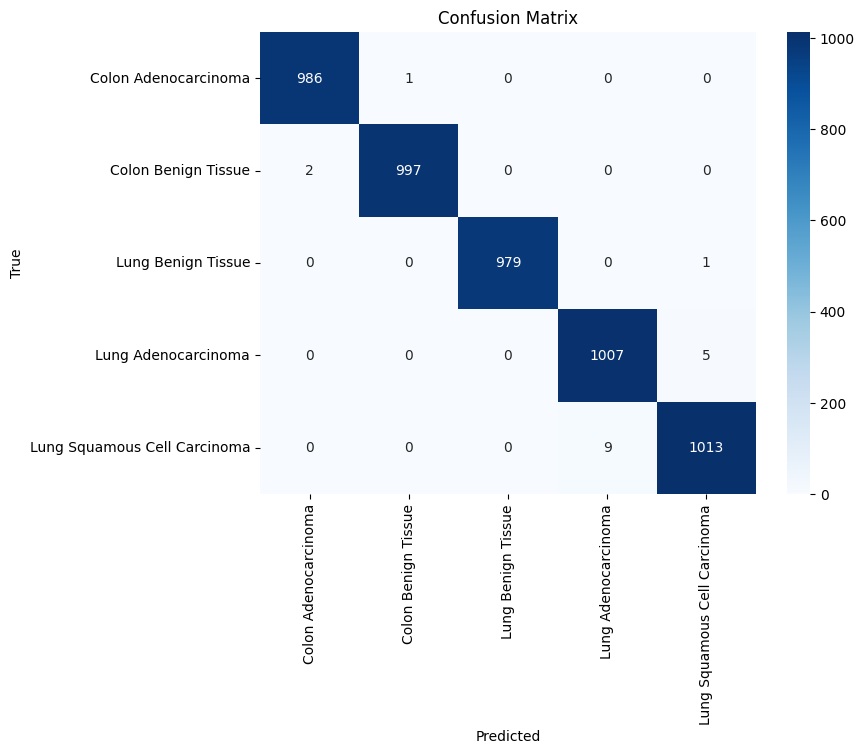

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Resnet 34
Download do modelo pré-treinado:

In [ ]:
model = torchvision.models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

Treinamento:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #print("loss, loss, loss", running_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainset)}")
    loss_progress.append(running_loss / len(trainset))

Training epoch 1...
Epoch [1/20] - Loss: 0.005314527087635361
Training epoch 2...
Epoch [2/20] - Loss: 0.0024750100288743852
Training epoch 3...
Epoch [3/20] - Loss: 0.0017406470149420783
Training epoch 4...
Epoch [4/20] - Loss: 0.0011649550275520597
Training epoch 5...
Epoch [5/20] - Loss: 0.0008532159757698536
Training epoch 6...
Epoch [6/20] - Loss: 0.0006754500549686781
Training epoch 7...
Epoch [7/20] - Loss: 0.000664667419653415
Training epoch 8...
Epoch [8/20] - Loss: 0.0005336940432967822
Training epoch 9...
Epoch [9/20] - Loss: 0.0004515532897132289
Training epoch 10...
Epoch [10/20] - Loss: 0.00034902620873290287
Training epoch 11...
Epoch [11/20] - Loss: 0.0003239004522335563
Training epoch 12...
Epoch [12/20] - Loss: 0.0004503512465695167
Training epoch 13...
Epoch [13/20] - Loss: 0.0002367788706709689
Training epoch 14...
Epoch [14/20] - Loss: 0.00025226599107490985
Training epoch 15...
Epoch [15/20] - Loss: 0.0003438219082136129
Training epoch 16...
Epoch [16/20] - Loss: 

Gráfico da loss:

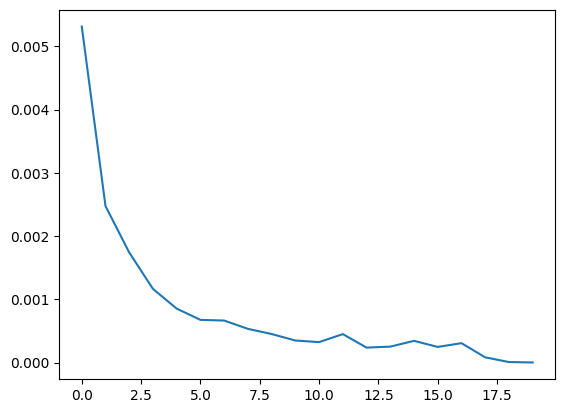

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.62%


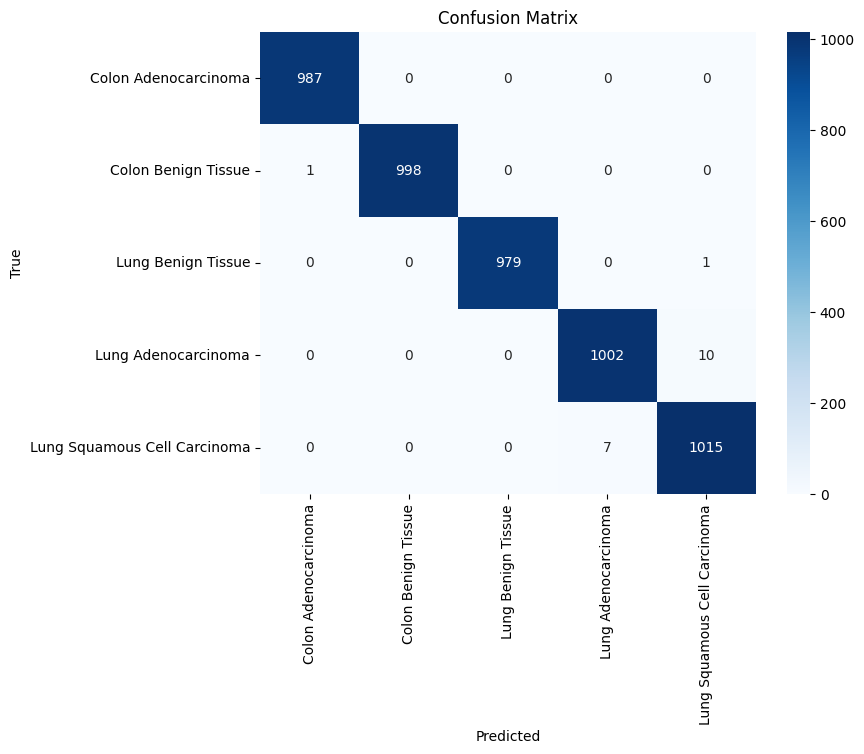

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### DenseNet 121
Download do modelo pré-treinado:

In [ ]:
model = torchvision.models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 278MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_classes = 5
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

Treinamento:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    loss_progress.append(running_loss / len(trainloader))

Training epoch 1...
Epoch [1/20] - Loss: 0.1228240906201303
Training epoch 2...
Epoch [2/20] - Loss: 0.05396519681550562
Training epoch 3...
Epoch [3/20] - Loss: 0.03285926070446148
Training epoch 4...
Epoch [4/20] - Loss: 0.02302587579782121
Training epoch 5...
Epoch [5/20] - Loss: 0.019632421507826073
Training epoch 6...
Epoch [6/20] - Loss: 0.018124847000604495
Training epoch 7...
Epoch [7/20] - Loss: 0.011511892915912904
Training epoch 8...
Epoch [8/20] - Loss: 0.016816796589130534
Training epoch 9...
Epoch [9/20] - Loss: 0.009713004339300096
Training epoch 10...
Epoch [10/20] - Loss: 0.005186786945478525
Training epoch 11...
Epoch [11/20] - Loss: 0.015349125443270896
Training epoch 12...
Epoch [12/20] - Loss: 0.011877196943270973
Training epoch 13...
Epoch [13/20] - Loss: 0.0043459932721103545
Training epoch 14...
Epoch [14/20] - Loss: 0.00042830976920959075
Training epoch 15...
Epoch [15/20] - Loss: 0.00017271082297665998
Training epoch 16...
Epoch [16/20] - Loss: 0.0001122473456

Gráfico da loss:

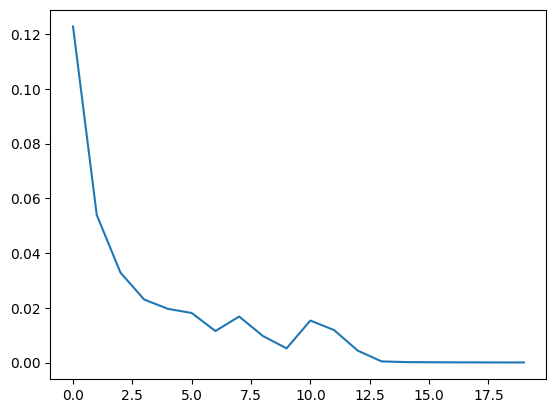

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.96%


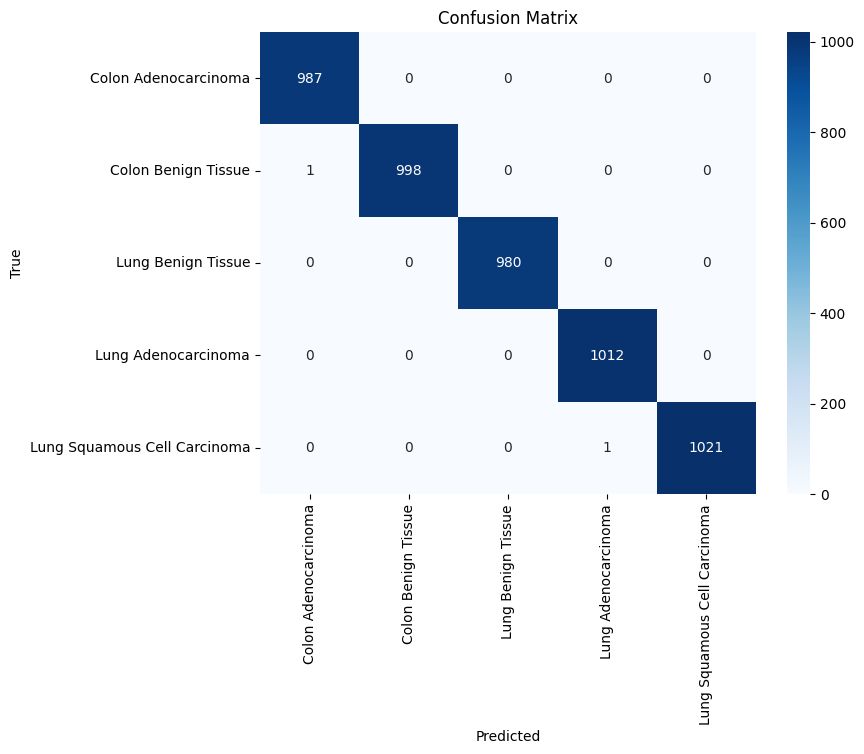

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### DenseNet 161
Download do modelo pré-treinado:

In [ ]:
model = torchvision.models.densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 233MB/s] 


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_classes = 5
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

Treinamento:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    loss_progress.append(running_loss / len(trainloader))

Training epoch 1...
Epoch [1/20] - Loss: 0.13824431315511465
Training epoch 2...
Epoch [2/20] - Loss: 0.059259021484851834
Training epoch 3...
Epoch [3/20] - Loss: 0.032954907703585924
Training epoch 4...
Epoch [4/20] - Loss: 0.02871457728985697
Training epoch 5...
Epoch [5/20] - Loss: 0.021731838106177747
Training epoch 6...
Epoch [6/20] - Loss: 0.016234975886531174
Training epoch 7...
Epoch [7/20] - Loss: 0.012053911352343858
Training epoch 8...
Epoch [8/20] - Loss: 0.014382293923129327
Training epoch 9...
Epoch [9/20] - Loss: 0.014144386176532135
Training epoch 10...
Epoch [10/20] - Loss: 0.01377897473430494
Training epoch 11...
Epoch [11/20] - Loss: 0.005527763668325497
Training epoch 12...
Epoch [12/20] - Loss: 0.014653570085484534
Training epoch 13...
Epoch [13/20] - Loss: 0.0018700364615942817
Training epoch 14...
Epoch [14/20] - Loss: 0.00033805160152260215
Training epoch 15...
Epoch [15/20] - Loss: 0.0001582626289979089
Training epoch 16...
Epoch [16/20] - Loss: 0.000100452333

Gráfico da loss:

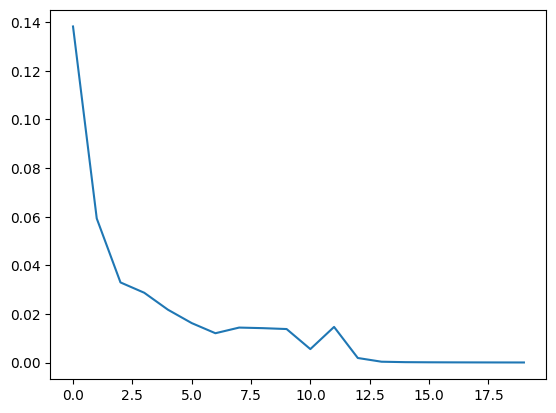

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.96%


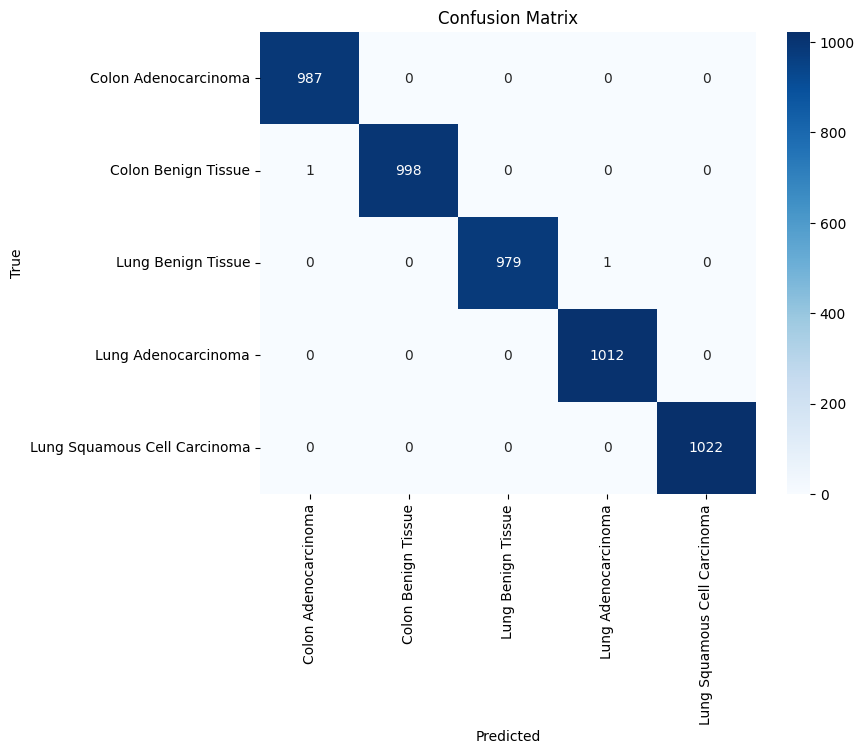

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### VGG 11
Download do modelo:

In [ ]:
model = torchvision.models.vgg11(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 101MB/s] 


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_classes = 5
model.classifier[6] = nn.Linear(4096, 5)

Treinamento:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    loss_progress.append(running_loss / len(trainloader))

Training epoch 1...
Epoch [1/20] - Loss: 1.0000048428058623
Training epoch 2...
Epoch [2/20] - Loss: 0.8301500689506531
Training epoch 3...
Epoch [3/20] - Loss: 0.559534765625
Training epoch 4...
Epoch [4/20] - Loss: 0.3457064858913422
Training epoch 5...
Epoch [5/20] - Loss: 0.2767933399617672
Training epoch 6...
Epoch [6/20] - Loss: 0.24010671763122082
Training epoch 7...
Epoch [7/20] - Loss: 0.20543323284834622
Training epoch 8...
Epoch [8/20] - Loss: 0.2844965316295624
Training epoch 9...
Epoch [9/20] - Loss: 0.18582692280709742
Training epoch 10...
Epoch [10/20] - Loss: 0.15371817212849856
Training epoch 11...
Epoch [11/20] - Loss: 0.14364536124169827
Training epoch 12...
Epoch [12/20] - Loss: 0.1353166040085256
Training epoch 13...
Epoch [13/20] - Loss: 0.1156545867845416
Training epoch 14...
Epoch [14/20] - Loss: 0.2187332946971059
Training epoch 15...
Epoch [15/20] - Loss: 0.11688541316427291
Training epoch 16...
Epoch [16/20] - Loss: 0.09823855414800346
Training epoch 17...
Ep

Gráfico da loss:

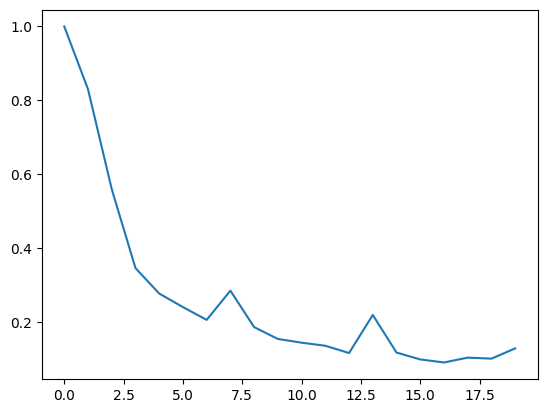

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.98%


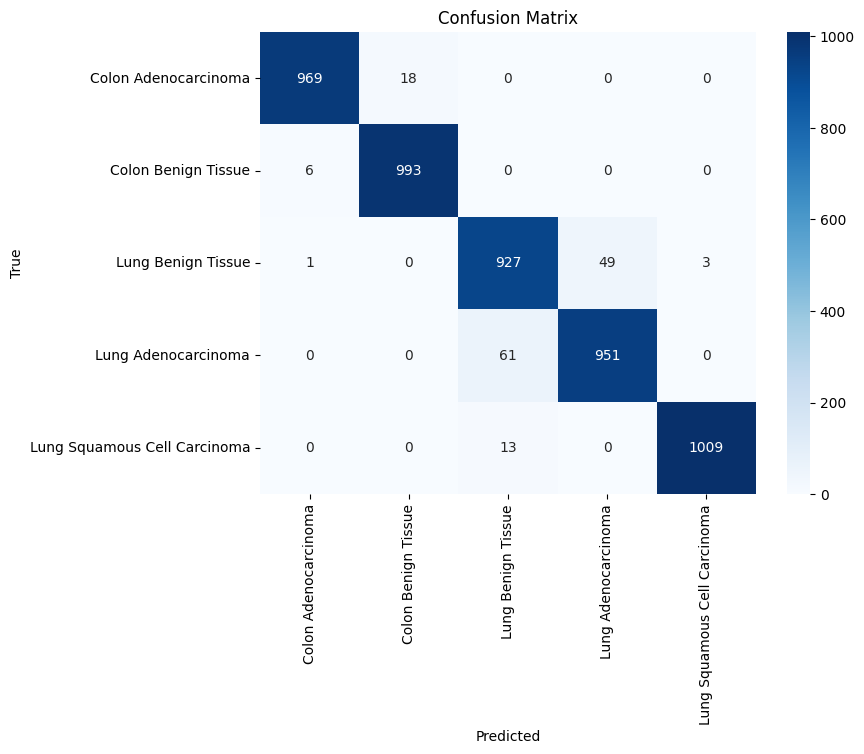

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### VGG 13
Download do modelo:

In [ ]:
model = torchvision.models.vgg13(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:02<00:00, 242MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.classifier[6] = nn.Linear(4096, 5)

Treinamento:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    loss_progress.append(running_loss / len(trainloader))

Training epoch 1...
Epoch [1/20] - Loss: 0.7492181564807892
Training epoch 2...
Epoch [2/20] - Loss: 0.645483512878418
Training epoch 3...
Epoch [3/20] - Loss: 0.6154176961421967
Training epoch 4...
Epoch [4/20] - Loss: 1.7241737961292267
Training epoch 5...
Epoch [5/20] - Loss: 1.6116177061080932
Training epoch 6...
Epoch [6/20] - Loss: 1.610521116065979
Training epoch 7...
Epoch [7/20] - Loss: 1.6109428314208984
Training epoch 8...
Epoch [8/20] - Loss: 1.6114725912094117
Training epoch 9...
Epoch [9/20] - Loss: 1.611282900238037
Training epoch 10...
Epoch [10/20] - Loss: 1.6111031841278076
Training epoch 11...
Epoch [11/20] - Loss: 1.61045521068573
Training epoch 12...
Epoch [12/20] - Loss: 1.6108830249786377
Training epoch 13...
Epoch [13/20] - Loss: 1.610880755996704
Training epoch 14...
Epoch [14/20] - Loss: 1.6103416217803954
Training epoch 15...
Epoch [15/20] - Loss: 1.6106960395812988
Training epoch 16...
Epoch [16/20] - Loss: 1.6104108501434327
Training epoch 17...
Epoch [17/2

Gráfico da loss:

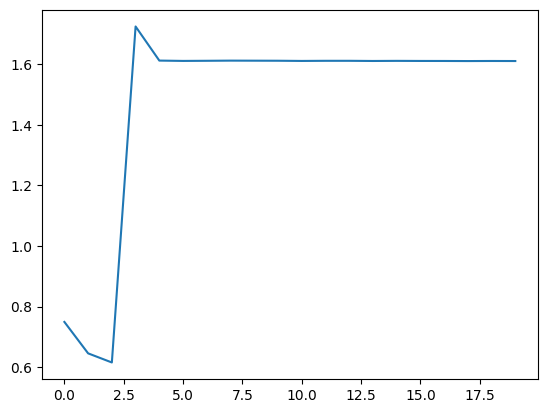

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 20.44%


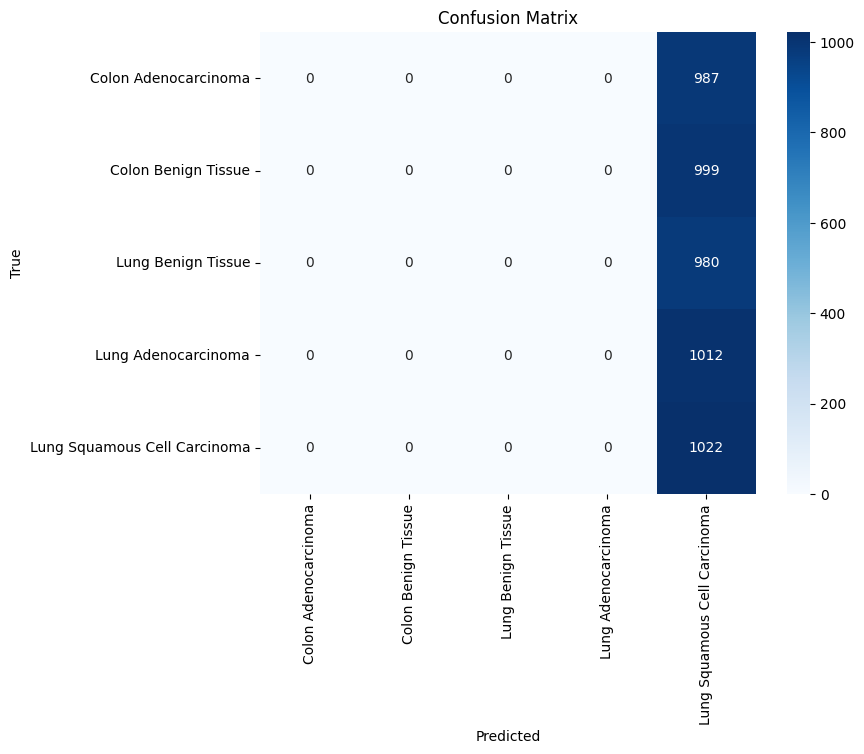

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()